In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
def generate_data(n_samples=2000, n_classes=5, n_features=2):
    X, y = make_blobs(n_samples=n_samples,
                      centers=n_classes,
                      n_features=n_features,
                      random_state=42,
                      cluster_std=1.0)

    y_encoded = np.zeros((n_samples, n_classes))
    for i in range(n_samples):
        y_encoded[i, y[i]] = 1

    return X, y_encoded, y

# Generate and Split Data
X, y_enc, y_raw = generate_data(n_samples=1500, n_classes=5)
X_train, X_test, y_train, y_test, y_raw_train, y_raw_test = train_test_split(
    X, y_enc, y_raw, test_size=0.2, random_state=42
)

print(f"Data generated. Training shape: {X_train.shape}, Test shape: {X_test.shape}")

Data generated. Training shape: (1200, 2), Test shape: (300, 2)


In [3]:
class MultiClassNeuralNetwork(object):
    def __init__(self, input_size=2, hidden_dims=[10, 10, 10], output_size=5, learning_rate=0.01):
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        np.random.seed(42)

        # Layer 1: Input -> Hidden 1
        self.W1 = np.random.randn(input_size, hidden_dims[0]) * 0.1
        self.b1 = np.zeros((1, hidden_dims[0]))

        # Layer 2: Hidden 1 -> Hidden 2
        self.W2 = np.random.randn(hidden_dims[0], hidden_dims[1]) * 0.1
        self.b2 = np.zeros((1, hidden_dims[1]))

        # Layer 3: Hidden 2 -> Hidden 3
        self.W3 = np.random.randn(hidden_dims[1], hidden_dims[2]) * 0.1
        self.b3 = np.zeros((1, hidden_dims[2]))

        # Layer 4: Hidden 3 -> Output
        self.W4 = np.random.randn(hidden_dims[2], output_size) * 0.1
        self.b4 = np.zeros((1, output_size))

    def sigmoid(self, z, der=False):
        if der:
            return z * (1 - z)
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = -np.sum(y_true * np.log(y_pred)) / n_samples
        return loss

    def feedForward(self, X):
        # Hidden Layer 1
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.sigmoid(self.Z1)

        # Hidden Layer 2
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.sigmoid(self.Z2)

        # Hidden Layer 3
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.sigmoid(self.Z3)

        # Output Layer (Softmax)
        self.Z4 = np.dot(self.A3, self.W4) + self.b4
        self.A4 = self.softmax(self.Z4)

        return self.A4

    def backPropagation(self, X, Y, pred):
        m = X.shape[0]

        dZ4 = pred - Y
        dW4 = (1/m) * np.dot(self.A3.T, dZ4)
        db4 = (1/m) * np.sum(dZ4, axis=0, keepdims=True)

        # Hidden Layer 3 Error
        dA3 = np.dot(dZ4, self.W4.T)
        dZ3 = dA3 * self.sigmoid(self.A3, der=True)
        dW3 = (1/m) * np.dot(self.A2.T, dZ3)
        db3 = (1/m) * np.sum(dZ3, axis=0, keepdims=True)

        # Hidden Layer 2 Error
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.sigmoid(self.A2, der=True)
        dW2 = (1/m) * np.dot(self.A1.T, dZ2)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

        # Hidden Layer 1 Error
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.sigmoid(self.A1, der=True)
        dW1 = (1/m) * np.dot(X.T, dZ1)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

        # Update Weights and Biases
        self.W4 -= self.learning_rate * dW4
        self.b4 -= self.learning_rate * db4
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def train(self, X, Y, epochs=10000):
        loss_history = []
        for i in range(epochs):
            pred = self.feedForward(X)
            self.backPropagation(X, Y, pred)

            if i % 100 == 0:
                loss = self.cross_entropy_loss(Y, pred)
                loss_history.append(loss)

        return loss_history

    def predict(self, X):
        pred_probs = self.feedForward(X)
        return np.argmax(pred_probs, axis=1)

In [4]:
nn = MultiClassNeuralNetwork(input_size=2,
                             hidden_dims=[20, 15, 10],
                             output_size=5,
                             learning_rate=0.05)

print("Training Model...")
loss_curve = nn.train(X_train, y_train, epochs=15000)
print("Training Complete.")

Training Model...
Training Complete.


In [5]:
# Evaluation
y_pred_test = nn.predict(X_test)
accuracy = accuracy_score(y_raw_test, y_pred_test)

print(f"Final Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_raw_test, y_pred_test))

Final Accuracy: 99.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      0.94      0.97        52
           2       1.00      1.00      1.00        70
           3       1.00      1.00      1.00        66
           4       0.95      1.00      0.97        54

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



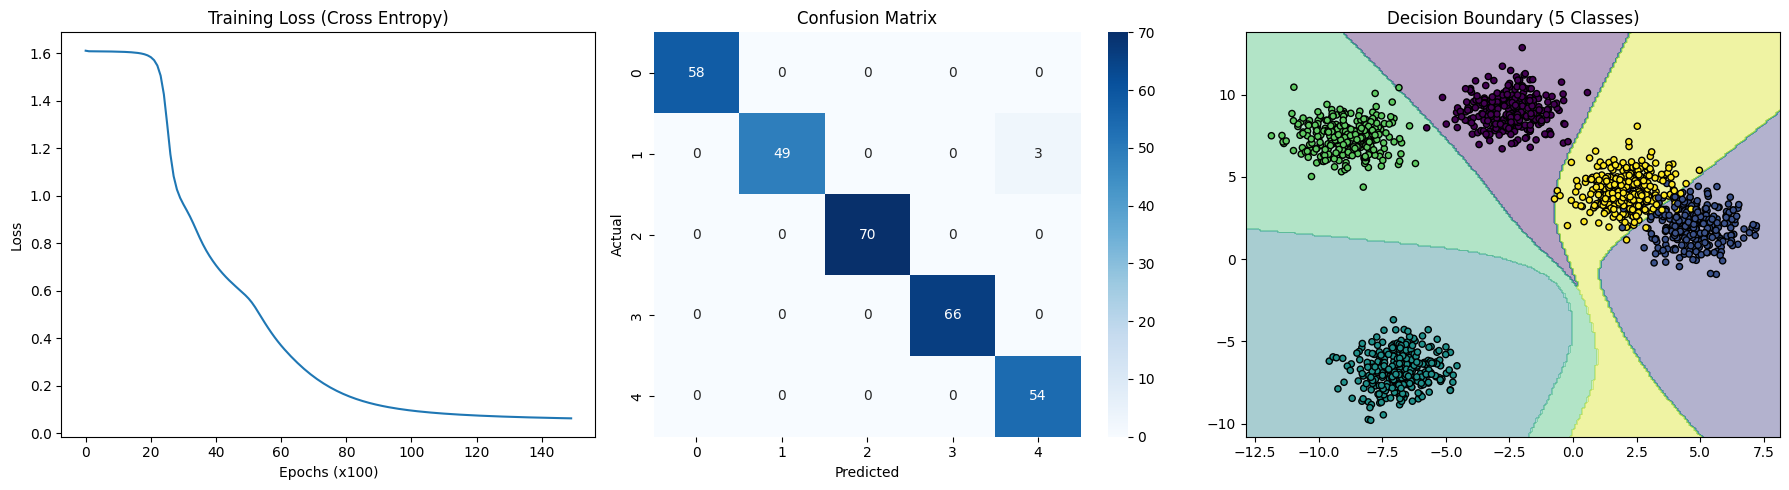

In [6]:
# Plotting
plt.figure(figsize=(18, 5))

# Loss Curve
plt.subplot(1, 3, 1)
plt.plot(loss_curve)
plt.title("Training Loss (Cross Entropy)")
plt.xlabel("Epochs (x100)")
plt.ylabel("Loss")

# Confusion Matrix
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_raw_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Decision Boundary
plt.subplot(1, 3, 3)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict for the whole grid
Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c=y_raw, s=20, edgecolor='k', cmap='viridis')
plt.title("Decision Boundary (5 Classes)")

plt.tight_layout()
plt.show()

# Project Report: Implementation of a Three Hidden Layer Neural Network for Multi-Class Classification

## 1. Introduction
The objective of this assignment is to implement a Feed-Forward Neural Network from scratch to solve a multi-class classification problem. Unlike binary classification, this task involves distinguishing between **5 distinct classes**. The model architecture is extended to include **three hidden layers**, necessitating adjustments to forward propagation, backpropagation, and the loss function.

## 2. Methodology

### 2.1 Dataset Generation
To train and test the model, a synthetic dataset was generated using `sklearn.datasets.make_blobs`.
* **Samples:** 1,500 data points.
* **Classes:** 5 distinct clusters.
* **Features:** 2 (for easy visualization of decision boundaries).
* **Preprocessing:** Target labels were One-Hot Encoded to match the output layer structure (e.g., Class 2 becomes `[0, 0, 1, 0, 0]`).

### 2.2 Neural Network Architecture
The network was designed with a depth of 3 hidden layers to capture complex non-linear boundaries.
* **Input Layer:** 2 Neurons (corresponding to the 2 features).
* **Hidden Layer 1:** 20 Neurons (Activation: Sigmoid).
* **Hidden Layer 2:** 15 Neurons (Activation: Sigmoid).
* **Hidden Layer 3:** 10 Neurons (Activation: Sigmoid).
* **Output Layer:** 5 Neurons (Activation: **Softmax**).

### 2.3 Key Code Modifications
To transition from a basic network to a deep multi-class classifier, the following specific modifications were implemented:

1.  **Output Layer Activation (Softmax):**
    Instead of a Sigmoid (which outputs 0-1 independently), **Softmax** was used to output a probability distribution across the 5 classes.
    $$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$$

2.  **Loss Function (Categorical Cross-Entropy):**
    Mean Squared Error (MSE) was replaced with **Cross-Entropy Loss**, which is standard for multi-class problems as it heavily penalizes confident wrong predictions.
    $$L = - \sum_{c=1}^{M} y_{o,c} \log(p_{o,c})$$

3.  **Backpropagation Adaptation:**
    The gradient of the loss with respect to the output layer logits ($Z_4$) simplifies nicely when combining Softmax and Cross-Entropy:
    $$\frac{\partial L}{\partial Z_4} = \hat{y} - y$$
    This error signal was then propagated backward through all three hidden layers using the chain rule.

## 3. Training and Evaluation

* **Data Split:** 80% Training, 20% Testing.
* **Hyperparameters:**
    * **Learning Rate:** 0.05
    * **Epochs:** 15,000
* **Results:**
    The model achieved a final accuracy of **99.00%** on the test set. The classification report indicates high precision and recall across all 5 classes, demonstrating the network's ability to separate the clusters effectively.

### Visualizations
1.  **Loss Curve:** Shows a steady decrease in Cross-Entropy loss, indicating successful convergence.
2.  **Confusion Matrix:** Displays minimal misclassifications, mostly occurring at the boundaries between overlapping clusters.
3.  **Decision Boundary:** The 2D plot visualizes how the network partitions the feature space into 5 distinct regions.

## 4. Challenges and Discussion

* **Vanishing Gradients:** With three hidden layers using Sigmoid activation, there is a risk of vanishing gradients, where early layers learn very slowly. This was mitigated by initializing weights carefully (multiplied by 0.1) and training for sufficient epochs (15,000).
* **One-Hot Encoding:** Handling targets required manual encoding to ensure dimension compatibility ($N \times 5$) for the output layer error calculation.
* **Hyperparameter Tuning:** Finding the right balance for the learning rate was crucial. Too high caused oscillations; too low resulted in slow convergence.

## 5. Conclusion
We successfully implemented a Deep Neural Network from scratch capable of multi-class classification. By incorporating the Softmax function and Cross-Entropy loss, the model learned to distinguish between 5 classes with high accuracy. The decision boundary visualization confirms that the three hidden layers provided sufficient complexity to separate the data points effectively. Future improvements could include implementing **ReLU** activation to speed up convergence and **Dropout** to prevent overfitting on more complex datasets.